## Big Processing Data


### Importation of Required Libraries
We're importing the following libraries for the project: Pyspark, Matplotlib, Seaborn, ...

Note: I am using Pycharm environment, so the environment is setup and doesn't need installation, but I'll also provide the code for install the libraries needed to run the project as well.

In [54]:
# Importing necessary libraries and modules for Spark-based data processing and machine learning tasks
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum as _sum, desc, asc, isnan, when, count
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Initialize Spark Session


In [55]:
# Initialize Spark Session
spark = SparkSession.builder.appName("BigDataProcessing").master("local[*]").getOrCreate()

# Verify Spark session creation by performing a simple operation
try:
    # Try creating a simple DataFrame and show it
    test_df = spark.range(5)  # Create a DataFrame with numbers 0 to 9
    test_df.show()  # Display the DataFrame
    print("Spark session is working and operational!")
except Exception as e:
    print(f"Error while verifying Spark session: {e}")

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+

Spark session is working and operational!


### Loading the Datasets
This section will focus on loading the following datasets: <b>DimProduct.csv, FactInternetSales.csv, DimCustomer.csv, DimProductCategory.csv, DimProductSubCategory.csv, DimDate.csv, DimSalesTerritory.csv, </b> for our processing and analysis.

In [56]:
# Load datasets
dim_product = spark.read.csv("Dataset/DimProduct.csv", header=True, inferSchema=True)
fact_sales = spark.read.csv("Dataset/FactInternetSales.csv", header=True, inferSchema=True)
dim_customer = spark.read.csv("Dataset/DimCustomer.csv", header=True, inferSchema=True)
dim_product_category = spark.read.csv("Dataset/DimProductCategory.csv", header=True, inferSchema=True)
dim_product_subcategory = spark.read.csv("Dataset/DimProductSubcategory.csv", header=True, inferSchema=True)
dim_sales_territory = spark.read.csv("Dataset/DimSalesTerritory.csv", header=True, inferSchema=True)
dim_date = spark.read.csv("Dataset/DimDate.csv", header=True, inferSchema=True)

### Exploratory Data Analysis


#### Summary Statistics
Exploring our datasets

In [57]:
# Display general information about the datasets
def explore_dataset(dataset, dataset_name):
    print(f"Exploring {dataset_name} Dataset:")

    # Show schema
    print(f"Schema of {dataset_name}:")
    dataset.printSchema()
    print("\n")

    # Show first few rows
    print(f"Sample data from {dataset_name}:")
    dataset.show(5, truncate=False)
    print("\n")

    # Count rows
    print(f"Total rows in {dataset_name}: {dataset.count()}")
    print("\n")

    # Check for missing values in each column
    print(f"Missing values per column in {dataset_name}:")
    dataset.select([(dataset[col].isNull().cast("int").alias(col)) for col in dataset.columns]) \
           .agg(*[sum(col(c)).alias(c) for c in dataset.columns]) \
           .show(truncate=False)
    print("\n")

    # Summary statistics for numerical columns
    print(f"Summary statistics for numerical columns in {dataset_name}:")
    dataset.describe().show(truncate=False)
    print("\n")

    # Distinct count for each column
    print(f"Distinct count for each column in {dataset_name}:")
    for col_name in dataset.columns:
        distinct_count = dataset.select(col_name).distinct().count()
        print(f"{col_name}: {distinct_count} distinct values")
    print("\n")

    # Check data types
    print(f"Data types in {dataset_name}:")
    dataset.dtypes
    print("\n")
    print("-" * 50)

In [53]:
# Explore each dataset
explore_dataset(dim_product, "DimProduct")

Exploring DimProduct Dataset:
Schema of DimProduct:
root
 |-- ProductKey: integer (nullable = true)
 |-- ProductAlternateKey: string (nullable = true)
 |-- ProductSubcategoryKey: integer (nullable = true)
 |-- WeightUnitMeasureCode: string (nullable = true)
 |-- SizeUnitMeasureCode: string (nullable = true)
 |-- EnglishProductName: string (nullable = true)
 |-- SpanishProductName: string (nullable = true)
 |-- FrenchProductName: string (nullable = true)
 |-- StandardCost: double (nullable = true)
 |-- FinishedGoodsFlag: boolean (nullable = true)
 |-- Color: string (nullable = true)
 |-- SafetyStockLevel: integer (nullable = true)
 |-- ReorderPoint: integer (nullable = true)
 |-- ListPrice: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- SizeRange: string (nullable = true)
 |-- Weight: double (nullable = true)
 |-- DaysToManufacture: integer (nullable = true)
 |-- ProductLine: string (nullable = true)
 |-- DealerPrice: double (nullable = true)
 |-- Class: string (nulla

+----------+-------------------+---------------------+---------------------+-------------------+-------------------------+---------------------------------+------------------------------------+------------+-----------------+-----+----------------+------------+---------+----+---------+------+-----------------+-----------+-----------+-----+-----+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------+----------------+----------------+-------+
|ProductKey|ProductAlternateKey|ProductSubcategoryKey|WeightUnitMeasureCode|SizeUnitMeasureCode|EnglishProductName       |SpanishProductName               |FrenchProductName                   |StandardCost|FinishedGoodsFlag|Color|SafetyStockLevel|ReorderPoint|ListPrice|Size|SizeRange|Weight|DaysToManufacture|ProductLine|DealerPrice|Class|Style|ModelName    |EnglishDescription                                                                         

Total rows in DimProduct: 606


Missing values per column in DimProduct:
+----------+-------------------+---------------------+---------------------+-------------------+------------------+------------------+-----------------+------------+-----------------+-----+----------------+------------+---------+----+---------+------+-----------------+-----------+-----------+-----+-----+---------+------------------+---------+-------+------+
|ProductKey|ProductAlternateKey|ProductSubcategoryKey|WeightUnitMeasureCode|SizeUnitMeasureCode|EnglishProductName|SpanishProductName|FrenchProductName|StandardCost|FinishedGoodsFlag|Color|SafetyStockLevel|ReorderPoint|ListPrice|Size|SizeRange|Weight|DaysToManufacture|ProductLine|DealerPrice|Class|Style|ModelName|EnglishDescription|StartDate|EndDate|Status|
+----------+-------------------+---------------------+---------------------+-------------------+------------------+------------------+-----------------+------------+-----------------+-----+----------------+-

+-------+------------------+-------------------+---------------------+---------------------+-------------------+------------------+---------------------------------+--------------------------+-----------------+------+------------------+------------------+-----------------+-----------------+---------+------------------+------------------+-----------+------------------+-----+-----+----------------------+---------------------------------------------------------------+----------------+----------------+-------+
|summary|ProductKey        |ProductAlternateKey|ProductSubcategoryKey|WeightUnitMeasureCode|SizeUnitMeasureCode|EnglishProductName|SpanishProductName               |FrenchProductName         |StandardCost     |Color |SafetyStockLevel  |ReorderPoint      |ListPrice        |Size             |SizeRange|Weight            |DaysToManufacture |ProductLine|DealerPrice       |Class|Style|ModelName             |EnglishDescription                                             |StartDate       |En

### Check and Clean the Datasets

In [38]:
#Data cleaning and checking for missing values
#Handle Missing Values
# Replace nulls in key columns with a placeholder (-1) or drop rows with missing keys
dim_product = dim_product.na.fill({"ProductSubcategoryKey": -1, "Color": "Unknown"}).na.drop(subset=["ProductKey"])
fact_sales = fact_sales.na.fill({"OrderQuantity": 0, "SalesAmount": 0}).na.drop(subset=["ProductKey", "CustomerKey"])
dim_customer = dim_customer.na.fill({"Gender": "Unknown", "YearlyIncome": 0})
dim_product_category = dim_product_category.na.fill({"EnglishProductCategoryName": "Unknown"})
dim_sales_territory = dim_sales_territory.na.fill({"SalesTerritoryRegion": "Unknown"})
dim_date = dim_date.na.drop(subset=["DateKey"])

In [46]:
### 4. Remove Duplicate Rows
# Drop duplicates from each dataset
dim_product = dim_product.dropDuplicates()
fact_sales = fact_sales.dropDuplicates()
dim_customer = dim_customer.dropDuplicates()
dim_product_category = dim_product_category.dropDuplicates()
dim_product_subcategory = dim_product_subcategory.dropDuplicates()
dim_sales_territory = dim_sales_territory.dropDuplicates()
dim_date = dim_date.dropDuplicates()


Metrics
Like total amount

## Business Questions
The Analysis will focus on the following product analysis, and sales analysis

- Product Analysis<br>

<b>Business Questions</b><br>
What are the most and least popular products?<br>
How does product performance vary across different categories and subcategories?<br>
Which products have the highest profitability margin?<br>
What are the top-selling products for specific sales territories?

In [47]:
#What are the most and least popular products?
## Join FactInternetSales with DimProduct to get product names
sales_data = fact_sales.join(dim_product, fact_sales.ProductKey == dim_product.ProductKey)


In [48]:
# Aggregate sales data to calculate total quantity sold for each product
product_popularity = sales_data.groupBy("EnglishProductName") \
    .agg(_sum("OrderQuantity").alias("TotalQuantitySold")) \
    .orderBy(desc("TotalQuantitySold"))  # Sort in descending order


In [49]:
# Most popular products
most_popular = product_popularity.limit(10)  # Top 10 most popular products
most_popular.show()

+--------------------+-----------------+
|  EnglishProductName|TotalQuantitySold|
+--------------------+-----------------+
|Water Bottle - 30...|             4244|
| Patch Kit/8 Patches|             3191|
|  Mountain Tire Tube|             3095|
|      Road Tire Tube|             2376|
|Sport-100 Helmet,...|             2230|
|        AWC Logo Cap|             2190|
|Sport-100 Helmet,...|             2125|
|Fender Set - Moun...|             2121|
|Sport-100 Helmet,...|             2085|
|Mountain Bottle Cage|             2025|
+--------------------+-----------------+



In [51]:
# Least popular products
least_popular = product_popularity.orderBy(asc("TotalQuantitySold")).limit(10)
least_popular.show()

+--------------------+-----------------+
|  EnglishProductName|TotalQuantitySold|
+--------------------+-----------------+
|Mountain-100 Silv...|               36|
|Mountain-500 Silv...|               39|
|Mountain-500 Blac...|               41|
|Mountain-100 Silv...|               42|
|Mountain-500 Silv...|               45|
|Mountain-500 Silv...|               45|
|Mountain-100 Blac...|               45|
|Touring-3000 Yell...|               47|
|Touring-3000 Blue...|               48|
|Mountain-500 Silv...|               48|
+--------------------+-----------------+



In [52]:
# Save results to CSV
most_popular.write.csv("Dataset/New/MostPopularProducts.csv", header=True)
least_popular.write.csv("Dataset/New/LeastPopularProducts.csv", header=True)

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/apple2015/Documents/MSc/SchoolStuff/Bigdata/coursework/project/BigDataProcessing/Dataset/New/MostPopularProducts.csv already exists. Set mode as "overwrite" to overwrite the existing path.

### Visualizing the Most and Least Popular Products

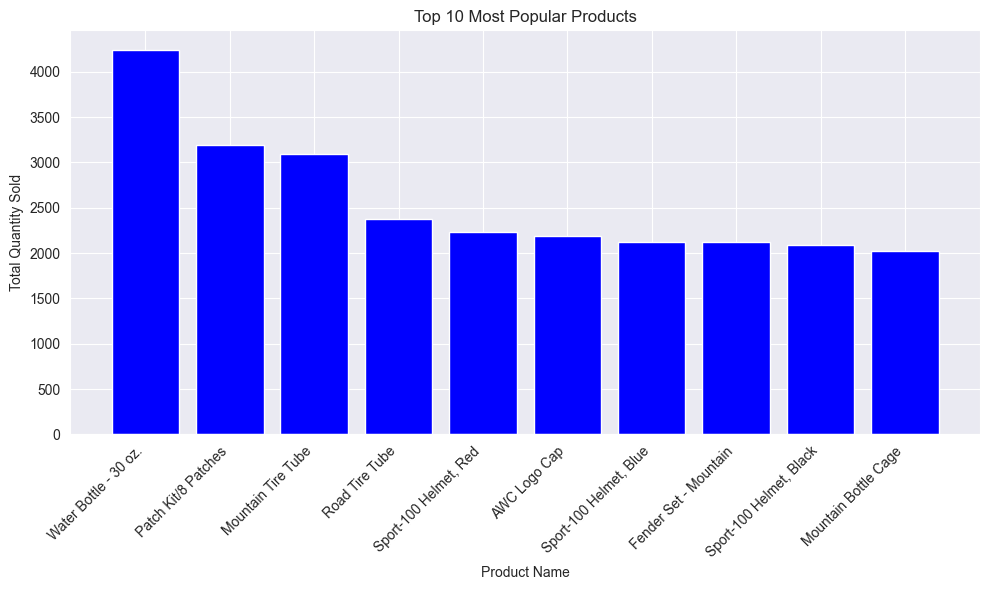

In [26]:
# Convert PySpark DataFrames to Pandas
most_popular_pd = most_popular.toPandas()
least_popular_pd = least_popular.toPandas()

# Visualization for Most Popular Products
plt.figure(figsize=(10, 6))
plt.bar(most_popular_pd['EnglishProductName'], most_popular_pd['TotalQuantitySold'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Popular Products')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.tight_layout()
plt.show()


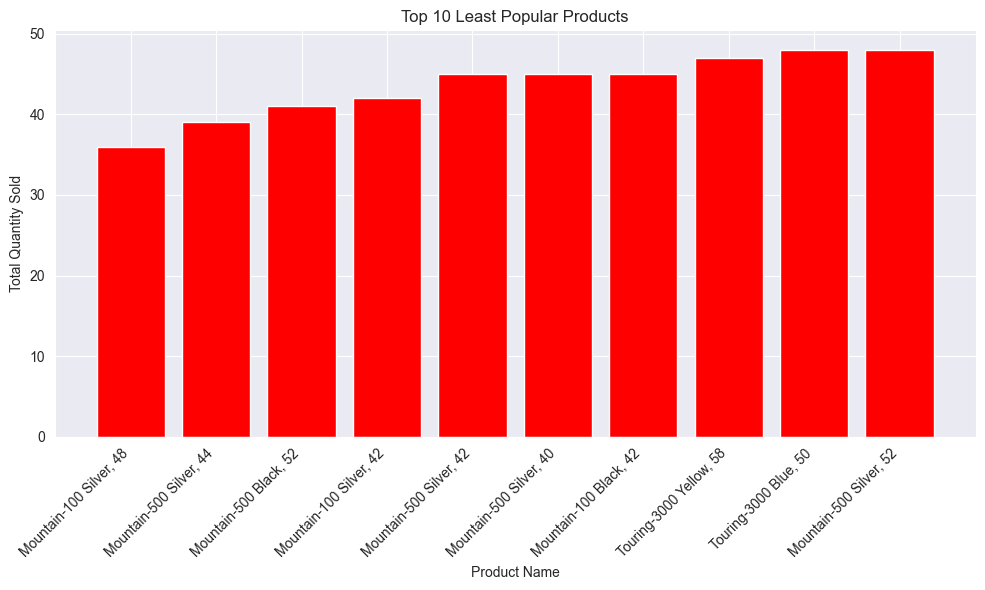

In [27]:

# Visualization for Least Popular Products
plt.figure(figsize=(10, 6))
plt.bar(least_popular_pd['EnglishProductName'], least_popular_pd['TotalQuantitySold'], color='red')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Least Popular Products')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.tight_layout()
plt.show()

Checking Product Performance Across Categories and Subcategories

In [28]:
#How does product performance vary across different categories and subcategories?"
# Join tables to get Product → Subcategory → Category hierarchy
product_data = fact_sales.join(dim_product, "ProductKey") \
    .join(dim_product_subcategory, "ProductSubcategoryKey") \
    .join(dim_product_category, "ProductCategoryKey")


In [29]:
# Aggregate data to calculate Total Sales and Quantity Sold
performance_data = product_data.groupBy("EnglishProductCategoryName", "EnglishProductSubcategoryName") \
    .agg(
        _sum("SalesAmount").alias("TotalSales"),
        _sum("OrderQuantity").alias("TotalQuantitySold")
    ).orderBy(col("TotalSales").desc())


In [30]:
# Show results
performance_data.show(truncate=False)

+--------------------------+-----------------------------+--------------------+-----------------+
|EnglishProductCategoryName|EnglishProductSubcategoryName|TotalSales          |TotalQuantitySold|
+--------------------------+-----------------------------+--------------------+-----------------+
|Bikes                     |Road Bikes                   |1.4520584036299847E7|8068             |
|Bikes                     |Mountain Bikes               |9952759.564400222   |4970             |
|Bikes                     |Touring Bikes                |3844801.0500000035  |2167             |
|Accessories               |Tires and Tubes              |245529.32000000443  |17332            |
|Accessories               |Helmets                      |225335.60000000076  |6440             |
|Clothing                  |Jerseys                      |172950.67999999886  |3332             |
|Clothing                  |Shorts                       |71319.81000000038   |1019             |
|Accessories        

Visualizing Product Performance Across Categories and Subcategories

In [31]:
# Convert PySpark DataFrame to Pandas for visualization
performance_pd = performance_data.toPandas()


In [33]:
performance_data.printSchema()


root
 |-- EnglishProductCategoryName: string (nullable = true)
 |-- EnglishProductSubcategoryName: string (nullable = true)
 |-- TotalSales: double (nullable = true)
 |-- TotalQuantitySold: long (nullable = true)



In [34]:
print(performance_data.columns)


['EnglishProductCategoryName', 'EnglishProductSubcategoryName', 'TotalSales', 'TotalQuantitySold']


In [35]:
# Group data by EnglishProductCategoryName
category_performance = product_data.groupBy("EnglishProductCategoryName") \
    .agg(
        _sum("SalesAmount").alias("TotalSales"),
        _sum("OrderQuantity").alias("TotalQuantitySold")
    ).orderBy(col("TotalSales").desc())

# Show the results
category_performance.show(truncate=False)

+--------------------------+--------------------+-----------------+
|EnglishProductCategoryName|TotalSales          |TotalQuantitySold|
+--------------------------+--------------------+-----------------+
|Bikes                     |2.8318144650701128E7|15205            |
|Accessories               |700759.9599999422   |36092            |
|Clothing                  |339772.6100000149   |9101             |
+--------------------------+--------------------+-----------------+



In [36]:
# Convert PySpark DataFrame to Pandas DataFrame
category_performance_pd = category_performance.toPandas()

/var/folders/vq/2z3hvmh94k13pb_1b0fmr7wm0000gn/T/ipykernel_8678/2604839958.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


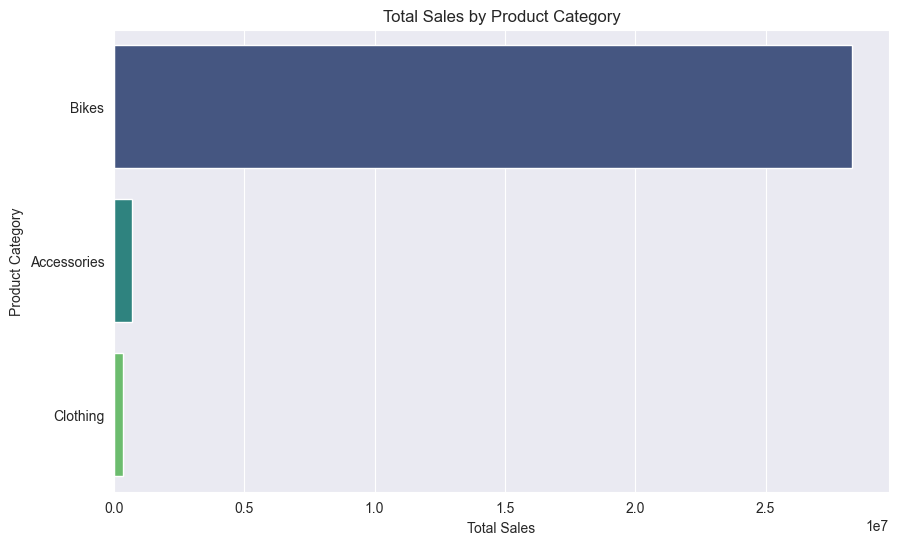

In [37]:
# Bar chart for Total Sales by Category
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_performance_pd,
    x="TotalSales",
    y="EnglishProductCategoryName",
    palette="viridis"
)
plt.title("Total Sales by Product Category")
plt.xlabel("Total Sales")
plt.ylabel("Product Category")
plt.show()

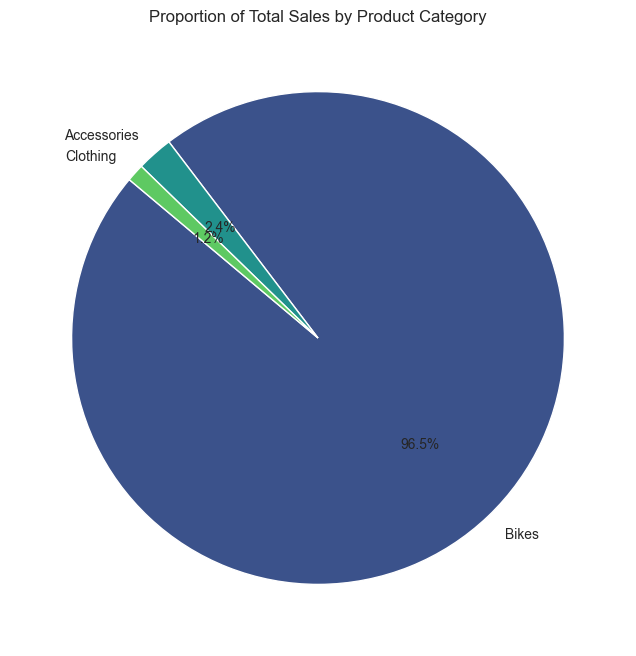

In [38]:
# Pie chart for Total Sales by Category
plt.figure(figsize=(8, 8))
plt.pie(
    category_performance_pd["TotalSales"],
    labels=category_performance_pd["EnglishProductCategoryName"],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("viridis", len(category_performance_pd))
)
plt.title("Proportion of Total Sales by Product Category")
plt.show()


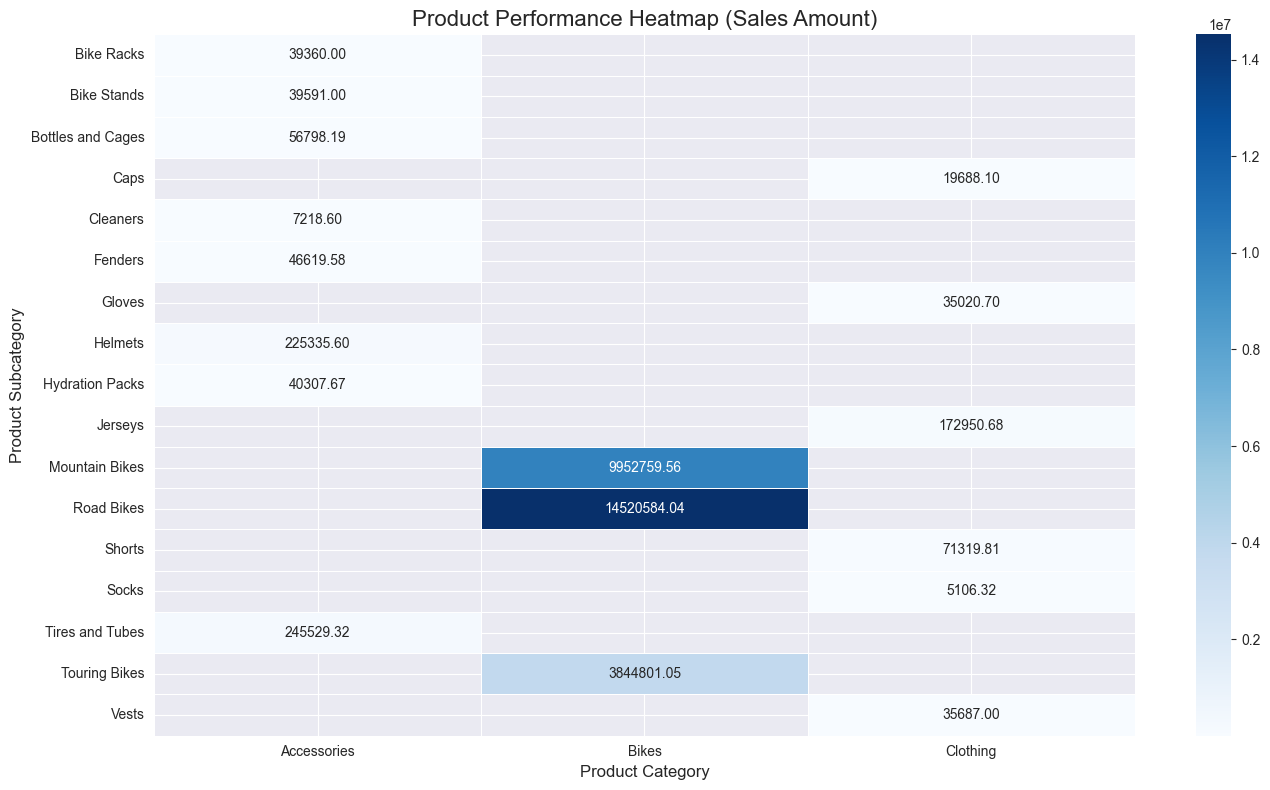

In [39]:
# Visualization 2: Heatmap (Category and Subcategory Performance)
# Pivot the data to create a 2D matrix
heatmap_data = performance_pd.pivot_table(
    index="EnglishProductSubcategoryName",  # Rows: Subcategories
    columns="EnglishProductCategoryName",  # Columns: Categories
    values="TotalSales",                   # Values: TotalSales
    aggfunc="sum"                          # Aggregation function (if duplicates exist)
)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,      # Annotate cells with data values
    fmt=".2f",       # Format numbers to two decimal places
    cmap="Blues",    # Color map
    linewidths=0.5   # Add lines between cells
)

# Add titles and labels
plt.title("Product Performance Heatmap (Sales Amount)", fontsize=16)
plt.xlabel("Product Category", fontsize=12)
plt.ylabel("Product Subcategory", fontsize=12)

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()



- Sales Analysis<br>
<b>Business Questions:</b><br>
Which products generate the highest sales revenue and profit margins?<br>
How do sales trends vary across different sales territories (DimSalesTerritory)?<br>
What are the most successful product categories and subcategories (DimProductCategory, DimProductSubcategory)?<br>
What is the trend in revenue and profit over time?

In [99]:
#Which products generate the highest sales revenue and profit margins?

# Join FactInternetSales and DimProduct
sales_data = fact_sales.join(
    dim_product,
    fact_sales.ProductKey == dim_product.ProductKey,
    how="inner"
)

In [96]:

# Calculate Total Revenue and Profit Margin for each product
sales_data = sales_data.withColumn(
    "TotalRevenue", col("SalesAmount")
).withColumn(
    "ProfitMargin",
    (col("SalesAmount") - (col("UnitPrice") * col("OrderQuantity"))) / col("SalesAmount")
)

In [98]:
sales_data.show()

+----------+------------+----------+-----------+-----------+------------+-----------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+-------------------+-------------------+-------------------+----------+-------------------+---------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+-----------------+------+----------------+------------+---------+----+---------+------+-----------------+-----------+-----------+-----+-----+------------+--------------------+----------------+----------------+------+------------+------------+
|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|CustomerKey|PromotionKey|CurrencyKey|SalesTerritoryKey|SalesOrderNumber|SalesOrderLineNumber|RevisionNumber|OrderQuantity|UnitPrice|ExtendedAm

In [100]:
# Aggregate revenue and profit margin by product
product_sales = sales_data.groupBy("ProductKey", "EnglishProductName").agg(
    sum("Revenue").alias("TotalRevenue"),
    avg("ProfitMargin").alias("AverageProfitMargin")
)

AnalysisException: [AMBIGUOUS_REFERENCE] Reference `ProductKey` is ambiguous, could be: [`ProductKey`, `ProductKey`].

In [ ]:
# Get the top products by revenue and profit margin
top_products_revenue = product_sales.orderBy(desc("TotalRevenue")).limit(10)
top_products_profit_margin = product_sales.orderBy(desc("AverageProfitMargin")).limit(10)


In [ ]:

# Convert to Pandas for visualization
top_revenue_df = top_products_revenue.toPandas()
top_profit_margin_df = top_products_profit_margin.toPandas()

### Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 products by revenue
plt.figure(figsize=(10, 6))
sns.barplot(data=top_revenue_df, x="TotalRevenue", y="EnglishProductName")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()

# Top 10 products by profit margin
plt.figure(figsize=(10, 6))
sns.barplot(data=top_profit_margin_df, x="AverageProfitMargin", y="EnglishProductName")
plt.title("Top 10 Products by Profit Margin")
plt.xlabel("Profit Margin")
plt.ylabel("Product")
plt.show()


### How do sales trends vary across different sales territories?


In [ ]:
#How do sales trends vary across different sales territories (DimSalesTerritory)?
# Join FactInternetSales with DimSalesTerritory to link sales data to territories
sales_territory = internet_sales.join(
    dim_sales_territory_df,
    fact_internet_sales_df.SalesTerritoryKey == dim_sales_territory_df.SalesTerritoryKey,
    "inner"
)

# Aggregate sales revenue by territory
territory_trends = sales_territory.groupBy("SalesTerritoryRegion", "CalendarYear").agg(
    sum("SalesAmount").alias("TotalRevenue")
)

# Sort by region and year
territory_trends = territory_trends.orderBy("SalesTerritoryRegion", "CalendarYear")

# Show results
territory_trends.show()


In [ ]:
#Which products generate the highest sales revenue and profit margins?


In [ ]:
#What are the most successful product categories and subcategories (DimProductCategory, DimProductSubcategory)?


In [ ]:
#What is the trend in revenue and profit over time?

### Predictions - Model development
Forcast Questions

- Which products are likely to see increased sales in the future?
- Can we predict customer churn or loyalty?
- Predicting Product Categories for Future Purchases

#### Predicting Product Categories for Future Purchases (Classification)

<b>Approach:</b><br>
For this task, we'll be us



Code Implementation (Using Random Forest)
1. Join Tables and Create Labels


In [48]:
# Step 1: Join FactInternetSales with DimProduct
sales_product = fact_sales.join(dim_product, "ProductKey", "inner")

# Step 2: Join with DimProductSubcategory
sales_product_subcategory = sales_product.join(dim_product_subcategory, "ProductSubcategoryKey", "inner")


# Step 3: Join with DimProductCategory
sales_product_category = sales_product_subcategory.join(dim_product_category, "ProductCategoryKey", "inner")


# Step 2: Join with DimProductCategory
# sales_product_category = sales_product.join(dim_product_category, "ProductCategoryKey", "inner")

# Step 3: Join with DimSalesTerritory
final_dataset = sales_product_category.join(dim_sales_territory, "SalesTerritoryKey", "inner")


In [49]:
final_dataset.show()

+-----------------+------------------+---------------------+----------+------------+----------+-----------+-----------+------------+-----------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+-------------------+-------------------+-------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+-----------------+------+----------------+------------+---------+----+---------+------+-----------------+-----------+-----------+-----+-----+------------+--------------------+----------------+----------------+------+------------------------------+-----------------------------+---------------------------+--------------------------+--------------------------+-------------------------+--------------------------+-------------

In [50]:
num_columns = len(final_dataset.columns)
print("Number of columns:", num_columns)

Number of columns: 63


In [51]:
# Step 4: Aggregate sales amount by region and product category
aggregated_data = final_dataset.groupBy("SalesTerritoryRegion", "EnglishProductCategoryName") \
    .agg(sum("SalesAmount").alias("TotalSalesAmount"))

# Show the aggregated data
aggregated_data.show()


+--------------------+--------------------------+------------------+
|SalesTerritoryRegion|EnglishProductCategoryName|  TotalSalesAmount|
+--------------------+--------------------------+------------------+
|      United Kingdom|               Accessories| 76630.04000000161|
|           Southeast|                  Clothing|300.94000000000005|
|           Australia|               Accessories|138690.62999999995|
|           Southeast|                     Bikes|11405.939600000002|
|              France|                     Bikes|2553575.7143000015|
|             Germany|                     Bikes| 2808514.348200001|
|              Canada|               Accessories|103377.85000000225|
|              Canada|                  Clothing| 53164.61999999997|
|           Northwest|               Accessories|110150.80000000201|
|             Germany|                  Clothing|23565.399999999885|
|             Central|               Accessories|232.45999999999998|
|             Germany|            

In [57]:
final_dataset.write.csv("Dataset/New/MostPopularProducts.csv", header=True)
# Step 5: Split the data into training and testing


In [54]:
# Prepare features and label
assembler = VectorAssembler(
    inputCols=["TotalSalesAmount"],
    outputCol="features"
)
data = assembler.transform(aggregated_data).select(col("features"), col("TotalSalesAmount").alias("label"))

# Split data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Step 6: Train a regression model (e.g., Linear Regression)
lr = LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction")
model = lr.fit(train_data)

# Step 7: Make predictions on test data
predictions = model.transform(test_data)
predictions.show()

# Step 8: Evaluate the model
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

25/01/07 20:12:26 WARN Instrumentation: [9fdc90f5] regParam is zero, which might cause numerical instability and overfitting.


+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[232.45999999999998]|232.45999999999998|232.46000000043102|
|         [2611.4096]|         2611.4096|2611.4096000004297|
|[11405.939600000002]|11405.939600000002|11405.939600000427|
| [58230.43000000014]| 58230.43000000014| 58230.43000000054|
|[103377.85000000225]|103377.85000000225|103377.85000000264|
|[1821302.3920999982]|1821302.3920999982| 1821302.392099998|
| [8852050.004400076]| 8852050.004400076| 8852050.004400073|
+--------------------+------------------+------------------+

Root Mean Squared Error (RMSE): 1.4539677786696573e-09


In [60]:
#most frequent product category a customer is likely to purchase based on their demographic information and purchase behavior
# Step 2: Join with DimCustomer
customer_product_sales = product_sales.join(dim_customer, "CustomerKey")


In [62]:
customer_product_sales.show()

+-----------+----------+------------+----------+-----------+------------+-----------+-----------------+----------------+--------------------+--------------+-------------+---------+--------------+--------------------+--------------+-------------------+----------------+-----------+--------+-------+---------------------+----------------+-------------------+-------------------+-------------------+-------------------+---------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+-----------------+------+----------------+------------+---------+----+---------+------+-----------------+-----------+-----------+-----+-----+------------+--------------------+----------------+----------------+------+------------+--------------------+-----+---------+----------+---------+---------+----------+-------------+------+------+--------------------+------------+-------------+--------------------+-------------------+-------------------

In [63]:
customer_product_sales.printSchema()


root
 |-- CustomerKey: integer (nullable = true)
 |-- ProductKey: integer (nullable = true)
 |-- OrderDateKey: integer (nullable = true)
 |-- DueDateKey: integer (nullable = true)
 |-- ShipDateKey: integer (nullable = true)
 |-- PromotionKey: integer (nullable = true)
 |-- CurrencyKey: integer (nullable = true)
 |-- SalesTerritoryKey: integer (nullable = true)
 |-- SalesOrderNumber: string (nullable = true)
 |-- SalesOrderLineNumber: integer (nullable = true)
 |-- RevisionNumber: integer (nullable = true)
 |-- OrderQuantity: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- ExtendedAmount: double (nullable = true)
 |-- UnitPriceDiscountPct: integer (nullable = true)
 |-- DiscountAmount: integer (nullable = true)
 |-- ProductStandardCost: double (nullable = true)
 |-- TotalProductCost: double (nullable = true)
 |-- SalesAmount: double (nullable = true)
 |-- TaxAmt: double (nullable = true)
 |-- Freight: double (nullable = true)
 |-- CarrierTrackingNumber: string (n

In [69]:
# Step 2: Join with DimProductSubcategory
customer_sales_product_subcategory = customer_product_sales.join(dim_product_subcategory, "ProductSubcategoryKey", "inner")


# Step 3: Join with DimProductCategory
customer_sales_product_category = sales_product_subcategory.join(dim_product_category, "ProductCategoryKey", "inner")



In [67]:
customer_sales_product_subcategory.printSchema()


root
 |-- ProductSubcategoryKey: integer (nullable = true)
 |-- CustomerKey: integer (nullable = true)
 |-- ProductKey: integer (nullable = true)
 |-- OrderDateKey: integer (nullable = true)
 |-- DueDateKey: integer (nullable = true)
 |-- ShipDateKey: integer (nullable = true)
 |-- PromotionKey: integer (nullable = true)
 |-- CurrencyKey: integer (nullable = true)
 |-- SalesTerritoryKey: integer (nullable = true)
 |-- SalesOrderNumber: string (nullable = true)
 |-- SalesOrderLineNumber: integer (nullable = true)
 |-- RevisionNumber: integer (nullable = true)
 |-- OrderQuantity: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- ExtendedAmount: double (nullable = true)
 |-- UnitPriceDiscountPct: integer (nullable = true)
 |-- DiscountAmount: integer (nullable = true)
 |-- ProductStandardCost: double (nullable = true)
 |-- TotalProductCost: double (nullable = true)
 |-- SalesAmount: double (nullable = true)
 |-- TaxAmt: double (nullable = true)
 |-- Freight: double (

In [70]:
customer_sales_product_category.printSchema()

root
 |-- ProductCategoryKey: integer (nullable = true)
 |-- ProductSubcategoryKey: integer (nullable = true)
 |-- ProductKey: integer (nullable = true)
 |-- OrderDateKey: integer (nullable = true)
 |-- DueDateKey: integer (nullable = true)
 |-- ShipDateKey: integer (nullable = true)
 |-- CustomerKey: integer (nullable = true)
 |-- PromotionKey: integer (nullable = true)
 |-- CurrencyKey: integer (nullable = true)
 |-- SalesTerritoryKey: integer (nullable = true)
 |-- SalesOrderNumber: string (nullable = true)
 |-- SalesOrderLineNumber: integer (nullable = true)
 |-- RevisionNumber: integer (nullable = true)
 |-- OrderQuantity: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- ExtendedAmount: double (nullable = true)
 |-- UnitPriceDiscountPct: integer (nullable = true)
 |-- DiscountAmount: integer (nullable = true)
 |-- ProductStandardCost: double (nullable = true)
 |-- TotalProductCost: double (nullable = true)
 |-- SalesAmount: double (nullable = true)
 |-- TaxA

In [72]:

# Step 3: Aggregate data to find the most frequent product category per customer
# customer_labels = customer_product_sales.groupBy("CustomerKey", "EnglishProductCategoryName") \
#     .agg(count("SalesAmount").alias("PurchaseCount")) \
#     .orderBy("CustomerKey", desc("PurchaseCount"))


customer_labels = customer_sales_product_category.groupBy("CustomerKey", "EnglishProductCategoryName") \
    .agg(count("SalesAmount").alias("PurchaseCount")) \
    .orderBy("CustomerKey", desc("PurchaseCount"))

In [74]:
customer_labels.show()

+-----------+--------------------------+-------------+
|CustomerKey|EnglishProductCategoryName|PurchaseCount|
+-----------+--------------------------+-------------+
|      11000|               Accessories|            4|
|      11000|                     Bikes|            3|
|      11000|                  Clothing|            1|
|      11001|               Accessories|            6|
|      11001|                     Bikes|            3|
|      11001|                  Clothing|            2|
|      11002|                     Bikes|            3|
|      11002|               Accessories|            1|
|      11003|               Accessories|            5|
|      11003|                     Bikes|            3|
|      11003|                  Clothing|            1|
|      11004|               Accessories|            3|
|      11004|                     Bikes|            3|
|      11005|                     Bikes|            3|
|      11005|               Accessories|            3|
|      110

In [75]:
# Select the most frequent product category for each customer
customer_labels = customer_labels.groupBy("CustomerKey").agg(first("EnglishProductCategoryName").alias("MostFrequentCategory"))


In [76]:

# Join with DimCustomer for demographic data
customer_data = customer_labels.join(dim_customer, "CustomerKey")

Create Features

In [79]:
# Step 1: Encode the target variable (Product Category) as numeric
category_indexer = StringIndexer(inputCol="MostFrequentCategory", outputCol="label")
customer_data = category_indexer.fit(customer_data).transform(customer_data)


In [82]:

# Step 2: Select features (demographics + aggregated purchase behavior)
feature_columns = ["YearlyIncome", "TotalChildren", "NumberCarsOwned"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [83]:

# Step 3: Transform the dataset
ml_data = assembler.transform(customer_data).select("features", "label")

3. Split Data and Train Random Forest Classifier

In [84]:

# Split into training and test datasets
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)


In [87]:

# Train a Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
rf_model = rf.fit(train_data)


In [93]:
# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)


# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.6085761407366685


###

In [21]:
# Stop the current Spark session spark.stop()
spark.stop()


ConnectionRefusedError: [Errno 61] Connection refused